## Forecasting forex using ARIMA for USD/VND 
The purpose of this research is to forecast usd/vnd exchamge rate to use in our investment analysis.

# Import packages

In [2]:
# Import packages
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas import DataFrame
from pandas_datareader import data as wb
from matplotlib import pyplot

from pmdarima.arima import auto_arima
from datetime import datetime
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

## Input data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


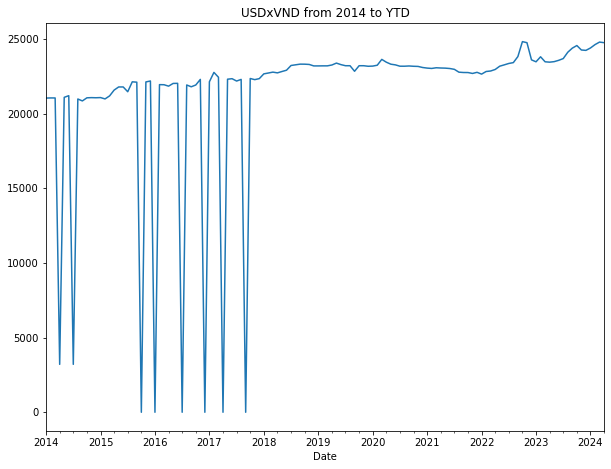

In [3]:
yf.pdr_override()

data = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31', interval = '1mo')

# Obtain latest vnd to usd rate
df_conv = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31')
data1 = 1/df_conv
vnd_to_usd = data1.iloc[-1,0]

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2014 to YTD")
plt.show()

df = pd.DataFrame(data['Adj Close']) 


## Stationary test

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


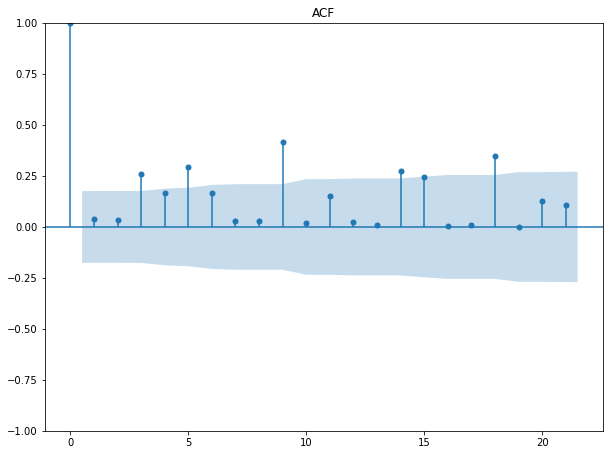

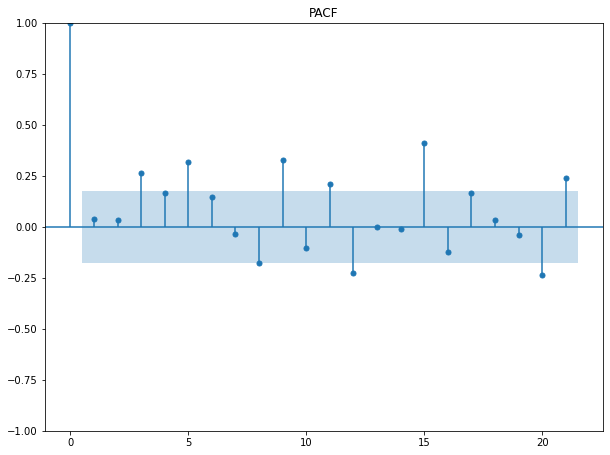

In [4]:
# Autocorrelation and partial correlation function of data
plot_acf(df['Adj Close'])
plt.title("ACF")
plot_pacf(df['Adj Close'])
plt.title("PACF")
plt.show()

In [5]:
adftest = adfuller(df['Adj Close'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.692386081814203
P-Value: 0.23925751934222
Number of lags: 11
Number of observations: 112
Critical Values: {'1%': -4.041963001634247, '5%': -3.4504426407047193, '10%': -3.1504645425245994}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


## Differencing 

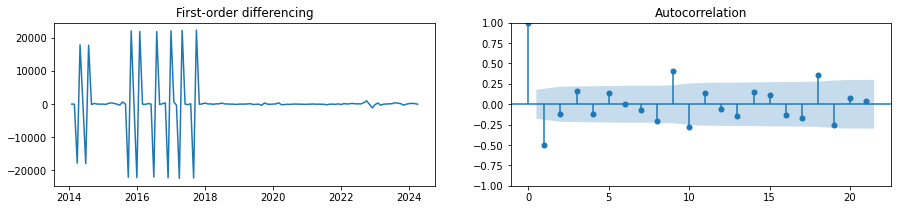

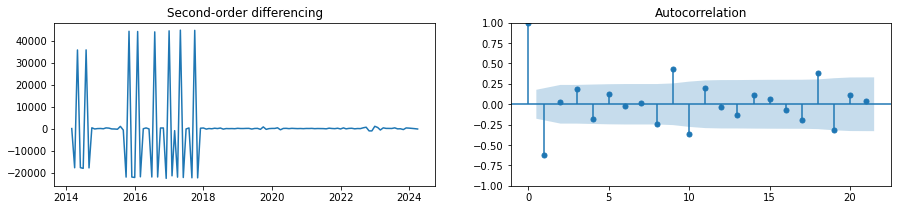

In [6]:
# First-order differencing
df['diff1'] = df['Adj Close'].diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('First-order differencing')
ax1.plot(df['diff1'])

df['growth_1'] = df['diff1']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(df['diff1'].dropna(), ax=ax2)
plt.show()

# Second order differencing
df['diff2'] = df['Adj Close'].diff().diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('Second-order differencing')
ax1.plot(df['diff2'])

df['growth_2'] = df['diff2']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(df['diff2'].dropna(), ax=ax2)
plt.show()



In [7]:
# Test stationarity with ADF
adftest = adfuller(df['growth_1'].dropna(), autolag = 'AIC', regression = 'n')
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")


ADF Test Results
Null Hypothesis: The series has an Unit Root
ADF-Statistic: -4.841382267939223
P-Value: 2.147309600437084e-06
Number of lags: 13
Number of observations: 109
Critical Values {'1%': -2.586557203939062, '5%': -1.9437233356164225, '10%': -1.6145921490406778}
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


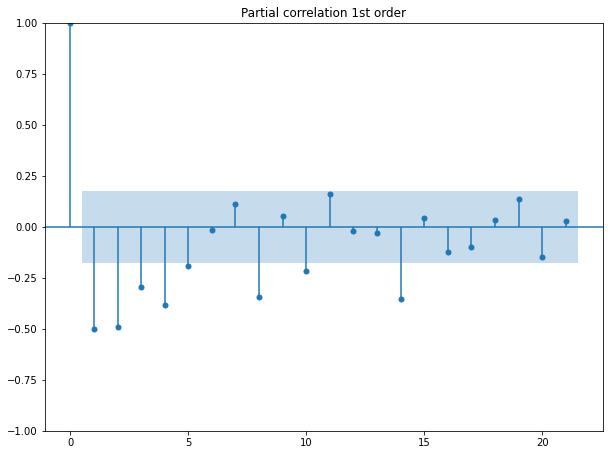

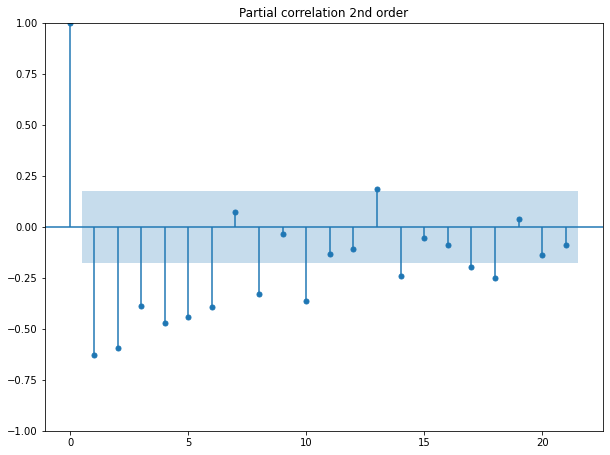

In [8]:
# Partial autocorrelation
plot_pacf(df['diff1'].dropna(),method='ywm')
plt.title('Partial correlation 1st order')
plt.show()

plot_pacf(df['diff2'].dropna(),method='ywm')
plt.title('Partial correlation 2nd order')
plt.show()

# ARIMA model parameters

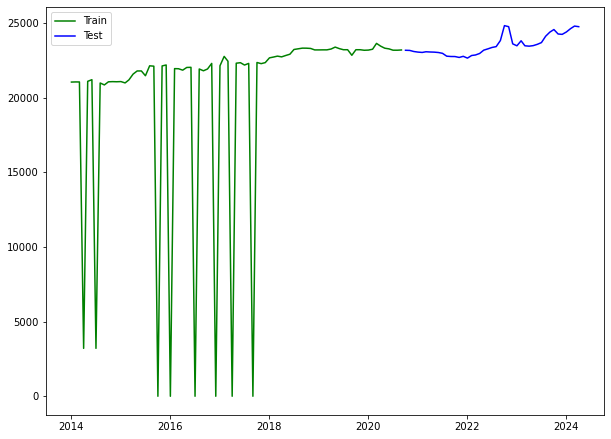

In [9]:
# Seperate into train and test data
to_row = int(len(df)*0.66)

df_train = list(df[0:to_row]['Adj Close'])
df_test = list(df[to_row:]['Adj Close'])

# Plot
plt.plot(df[0:to_row]['Adj Close'], 'green', label='Train')
plt.plot(df[to_row:]['Adj Close'],'blue',label='Test')
plt.legend()
plt.show()

In [10]:
# Finding ARIMA parameters automatically
model = auto_arima(df[0:to_row]['Adj Close'].dropna(), seasonal=False, stepwise= False, d= None, suppress_warnings=True)
print(model.order)

(0, 1, 3)


In [44]:
model_predictions = []
n_test_obser = len(df_test)

p = 0
d = 1
q = 3

for i in range(n_test_obser):
    model = ARIMA(df_train, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)
    model_predictions.append(yhat)
    actual_test_value = df_test[i]
    df_train.append(actual_test_value)

In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -2410.458
Date:                Fri, 05 Apr 2024   AIC                           4828.916
Time:                        15:45:35   BIC                           4843.018
Sample:                             0   HQIC                          4834.591
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0674      0.040    -26.977      0.000      -1.145      -0.990
ma.L2          0.0325      0.070      0.467      0.641      -0.104       0.169
ma.L3          0.2256      0.041      5.490      0.000       0.145       0.306
sigma2      1.142e+07    2.4e-09   4.76e+15      0.000    1.14e+07    1.14e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              2663.35
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.24e+31. Standard errors may be unstable.
"""

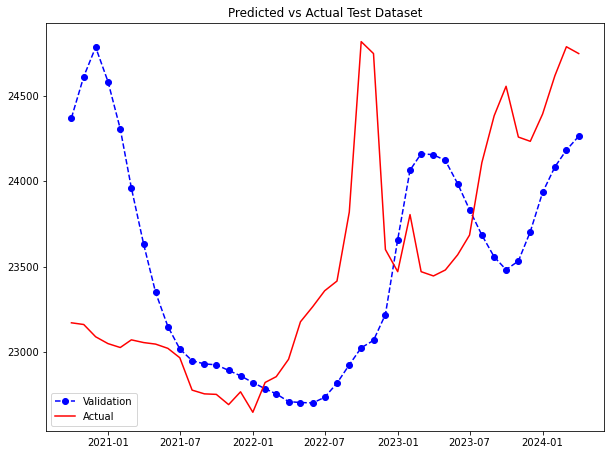

In [46]:
date_range = df[to_row:].index
plt.plot(date_range, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(date_range, df_test, color = 'red', label = 'Actual')
plt.legend()
plt.title('Predicted vs Actual Test Dataset')
plt.show()

# Evaluate model predictions

In [47]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, model_predictions)*vnd_to_usd
mape = mean_absolute_percentage_error(df_test, model_predictions)*vnd_to_usd
mse = (mean_squared_error(df_test, model_predictions))*vnd_to_usd
rmse = np.sqrt(mean_squared_error(df_test, model_predictions))*vnd_to_usd

print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 0.02449356756720498
mse: 24.138361459360237
mape: 1.0345425606239444e-06
rmse: 0.031113524261863888


In [48]:
testScore = np.sqrt(mean_squared_error(df_test, model_predictions))

testScore = testScore*vnd_to_usd

print('Test Score: %.6f RMSE' % (testScore))

rmspe = (np.sqrt(np.mean(np.square(np.subtract(df_test,model_predictions) / df_test)))) * 100
print('Test Score: %.6f RMSPE' % (rmspe))

Test Score: 0.031114 RMSE
Test Score: 3.853565 RMSPE


# Forecast into the future

In [49]:
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

print("Forecasted values:")
print(forecast)

Forecasted values:
[24264.82035427 24404.86763346 24541.42603829 24541.42603829
 24541.42603829 24541.42603829 24541.42603829 24541.42603829
 24541.42603829 24541.42603829 24541.42603829 24541.42603829]


In [50]:
from pandas.tseries.offsets import DateOffset

future_dates = [df.index[-1] + DateOffset(months = x) for x in range (0,forecast_steps+1)]
future_dates_df = pd.DataFrame(index = future_dates[1:], columns = df.columns)
comb_df = pd.concat([df[to_row:], future_dates_df])

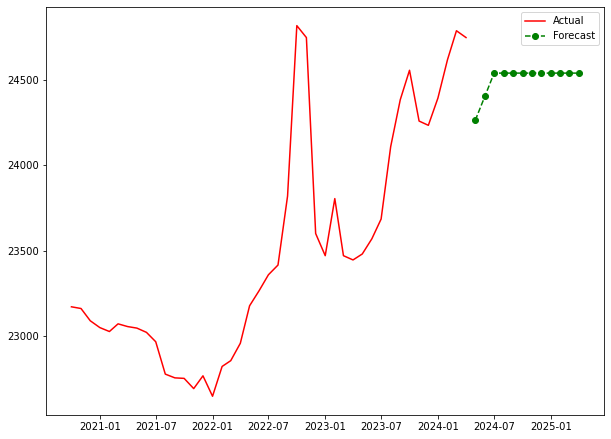

In [51]:
plt.plot(df[to_row:].index, df[to_row:]['Adj Close'], color = 'red', label = 'Actual')
plt.plot(future_dates_df.index, forecast, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.legend()

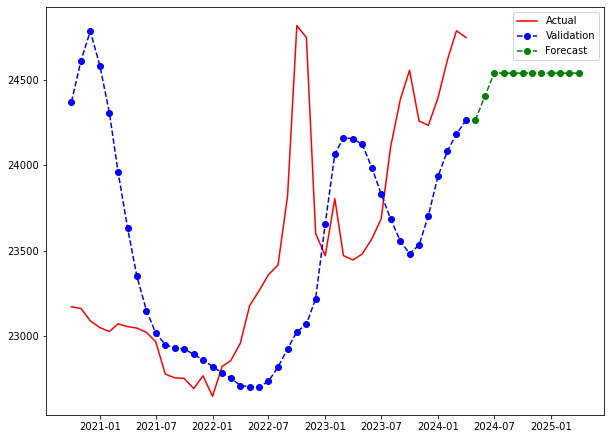

In [52]:
plt.plot(df[to_row:].index, df[to_row:]['Adj Close'], color = 'red', label = 'Actual')
plt.plot(df[to_row:].index, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(future_dates_df.index, forecast, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.legend()

# Check fit